<a href="https://colab.research.google.com/github/asadm11/Customer-Behaviour-Prediction-For-Online-Shopping/blob/main/Customer_behaviour_Prediction_For_Online_Shopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Returning Classification Analysis with ML

Hi! Welcome to the notebook!

This notebook will serve as the step by step code explanation on how I analyse the e-commerce dataset. The decision made based on the result will be summarized using Tableau Dashboard and a quick powerpoint presentation. Please do let me know if you have any suggestions for the methods I'm using in this notebook!

In [1]:
pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=345910047d5c7e154aed97de4a828011aee2a54664793f2fc4bbe992a691f016
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [2]:
pip install --upgrade sqlalchemy==1.4.27

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10


In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import statistics as stat
import math
from matplotlib import pyplot as plt
import datetime
import warnings
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [10]:
#import all needed datasets
#since there are a lot of datasets, I'm not going to show each of them.
custdb = pd.read_csv('/content/olist_customers_dataset.csv')
orderitems = pd.read_csv('/content/olist_order_items_dataset.csv', engine='c')
orderpmt = pd.read_csv('/content/olist_order_payments_dataset.csv')
orderreview = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orderdet = pd.read_csv('/content/olist_orders_dataset.csv')
productdb = pd.read_csv('/content/olist_products_dataset.csv')
sellerdb = pd.read_csv('/content/olist_sellers_dataset.csv')
prodtrans = pd.read_csv('/content/product_category_name_translation.csv')
geolocdb = pd.read_csv('/content/olist_geolocation_dataset.csv')

## Dataset Exploration

As part of our journey in using this dataset, it's best for us to understand the properties of what we are working on. Let's start with the very first step, data cleaning.

In [11]:
#check for NA values in category name then remove them to avoid errors
productdb[productdb.isna().any(axis=1)]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [12]:
#change product category to english, we use the english version from this point on
#using inner join immediately remove rows with no category name
engprod = pd.merge(productdb, prodtrans, on = 'product_category_name')
engprod = engprod.drop('product_category_name', axis = 1)

#check once more for incomplete rows
engprod[engprod.isna().any(axis=1)]

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
4037,09ff539a621711667c43eba6a3bd8466,60.0,865.0,3.0,NaN,NaN,NaN,NaN,baby


Since we're going to focus on the quantity in sales, we are going to keep this row.

Now, let's clean the other datasets, starting from finding incomplete rows. Below are the datasets I've found that had incomplete rows. The datasets that aren't listed below has complete rows, meaning no NA values.

In [13]:
#ORDER REVIEWS
orderreview[orderreview.isna().any(axis=1)]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


It is normal to have NA values in reviews because most of the time customers don't leave any review. So let's just keep it that way.

Now let's take a look at the order status in the order details dataset.

In [14]:
orderdet['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

From wrangling the data, here is what we can derive in regards of the normal flow of shipment:

Created -> Invoiced -> Approved -> Processing -> Shipped -> Delivered

with noting that:
- cancelation can occur anytime
- unavailable meaning the shipping could be delayed

After wrangling some more, this dataset shows the latest condition for each order_id, hence the dataset has unique records. Since our goal is to understand the purchasing behaviour, let's consider the delivered orders for now.

In [15]:
orderdets=orderdet[orderdet['order_status']=='delivered'].sort_values(by=['order_id'])
orderdets[orderdets.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaN,2017-11-20 19:44:47,2017-11-14 00:00:00
84999,2babbb4b15e6d2dfe95e2de765c97bce,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaN,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31 00:00:00
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaN,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20 00:00:00
72407,3c0b8706b065f9919d0505d3b3343881,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaN,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23 00:00:00


From this extract, we understand that some delivered orders have incomplete rows, in other words, invalid delivered orders. This might be an error in the tracking system or even worse, fake orders. But for now, let's keep this in mind and continue with our exploratory analysis. If somehow you decided to remove these rows from the beginning, that would do just fine since it only contains 23 incomplete records or covers approximately 0.023% of the full dataset.

The order items dataset has a unique way of tracking their purchases. Each order_id may have multiple order_item_id representing the same product. This is not a duplicate but merely represents the quantity of that product being purchased. For example, let's look at order_id '00571ded73b3c061925584feab0db425'.

In [16]:
orderitems[orderitems['order_id']=='f60ce04ff8060152c83c7c97e246d6a8']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
108262,f60ce04ff8060152c83c7c97e246d6a8,1,58efb9b638561ce132216a9a612513e2,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108263,f60ce04ff8060152c83c7c97e246d6a8,2,872db866d615db59612ac933f43d6b22,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108264,f60ce04ff8060152c83c7c97e246d6a8,3,872db866d615db59612ac933f43d6b22,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108265,f60ce04ff8060152c83c7c97e246d6a8,4,58efb9b638561ce132216a9a612513e2,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108266,f60ce04ff8060152c83c7c97e246d6a8,5,872db866d615db59612ac933f43d6b22,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108267,f60ce04ff8060152c83c7c97e246d6a8,6,872db866d615db59612ac933f43d6b22,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108268,f60ce04ff8060152c83c7c97e246d6a8,7,58efb9b638561ce132216a9a612513e2,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108269,f60ce04ff8060152c83c7c97e246d6a8,8,872db866d615db59612ac933f43d6b22,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108270,f60ce04ff8060152c83c7c97e246d6a8,9,58efb9b638561ce132216a9a612513e2,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04
108271,f60ce04ff8060152c83c7c97e246d6a8,10,58efb9b638561ce132216a9a612513e2,701938c450705b8ae65fc923b70f35c7,2017-12-04 22:31:28,109.97,34.04


But on the other hand, the order_item_id, which represents the number of products being purchased, might also note for multiple products. Here are order_id '005d9a5423d47281ac463a968b3936fb' for reference.

In [17]:
orderitems[orderitems['order_id']=='005d9a5423d47281ac463a968b3936fb']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
151,005d9a5423d47281ac463a968b3936fb,1,fb7a100ec8c7b34f60cec22b1a9a10e0,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,49.99,18.12
152,005d9a5423d47281ac463a968b3936fb,2,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58
153,005d9a5423d47281ac463a968b3936fb,3,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58


With these in mind, let's change the dataset to have order quantity for each product in each order instead of using order_item_id. Personally, using quantity is much easier than using this recording method. Albeit the unusual recording method, this would come in handy if each product is related with a campaign, such as promos. But that would be a talk for another day :)

In [18]:
#Create a temporary dataframe for the iteration process
orderqty=pd.DataFrame({})
tempdf = orderitems[['order_id','product_id']]
tempdf = tempdf.sort_values(['order_id','product_id'], ascending = [False,False])
orderqty['orderproduct']=list(zip(tempdf['order_id'],tempdf['product_id']))

In [19]:
#Looping process to acquire quantity per item in each order
item_qty = []
order_id=[]
prod_id=[]
i=0
for (orderid,prodid) in orderqty['orderproduct']:
    if i == 0:
        order_id.append(orderid)
        prod_id.append(prodid)
        cur_count = 1
        item_qty.append(cur_count)
    else:
        if orderqty['orderproduct'][i]==orderqty['orderproduct'][i-1]:
            cur_count = cur_count+1
            item_qty[-1]=cur_count
        else:
            order_id.append(orderid)
            prod_id.append(prodid)
            cur_count = 1
            item_qty.append(cur_count)
    i=i+1

orderqty = pd.DataFrame({})
orderqty['order_id']=order_id
orderqty['product_id']=prod_id
orderqty['item_qty']=item_qty
orderqty

,order_id,product_id,item_qty
0,fffe41c64501cc87c801fd61db3f6244,350688d9dc1e75ff97be326363655e01,1
1,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1
2,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1
3,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1
4,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1
...,...,...,...
102420,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1
102421,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1
102422,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1
102423,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1


In [20]:
#Revamped dataset
orderitems=orderitems.drop('order_item_id', axis = 1).sort_values(['order_id','product_id'], ascending = [False,False]).drop_duplicates(inplace=False)
orderitems = pd.merge(orderitems, orderqty, on = ['order_id','product_id'])
orderitems

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,item_qty
0,fffe41c64501cc87c801fd61db3f6244,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79,1
1,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,1
2,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,1
3,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1
4,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1
...,...,...,...,...,...,...,...
102420,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1
102421,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1
102422,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1
102423,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1


Looking good! :)

# Dataset Preparation

In this part, we will create few datasets to create our models. We will observe customer's loyalty by these factors:
- Order Review: customers who had great review on their order might have created a trust to purchase from the store
- Average Payment per Order: The higher the payment along with high order review would increase the retention rate towards the store since the customer had paid high amount with high satisfaction on the purchase.
- Freight Value to Payment Ratio: Higher freight value usually indicates longer distance between the seller and the customer or heavier items. The further the distance between the seller and the customer, the lower the frequency of purchase will be. Also, since heavier items tend to indicate one-time purchases, there might be lower chance for the customer to return.

## Data Wrangling

In this step, we will create a database for the delivered orders by merging each dataset appropiately. We will also create a summary for payment type used and product purchased per category from the existing orders. Since each order can use multiple payments, the payment records will be summarized into a seperate data frame with the number of payment types used in the order. This separation also applies when we're summarizing the number of products purchased by each category. Both summaries will be used for additional analysis.

In [21]:
#The delivered order dataset
orderdb = (orderdet[['customer_id','order_id']][orderdet['order_status']=='delivered']
           .merge(orderitems[['order_id','product_id','price','freight_value','item_qty']], how = 'left', on = 'order_id')
           .merge(engprod[['product_id','product_category_name_english']], how = 'left', on = 'product_id')
           .sort_values(by = 'customer_id')
          )
orderdb = orderdb.assign(total_price=orderdb['price']+orderdb['freight_value'])
orderdb = orderdb.assign(total_payment = orderdb['total_price']*orderdb['item_qty']).drop_duplicates()
orderdb

,customer_id,order_id,product_id,price,freight_value,item_qty,product_category_name_english,total_price,total_payment
69091,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,64315bd8c0c47303179dd2e25b579d00,89.80,24.94,1,toys,114.74,114.74
10120,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,84183944dc7cddca87a5d384452c1d3c,54.90,12.51,1,health_beauty,67.41,67.41
66385,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,9df2b21ec85378d71df4404712e17478,179.99,15.43,1,baby,195.42,195.42
43493,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,af3ec22cce878225aae6d9eb6c7a78eb,149.90,29.45,1,cool_stuff,179.35,179.35
5959,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,868b3136c5b206f91b8208fbfdf2cb7c,93.00,14.01,1,bed_bath_table,107.01,107.01
...,...,...,...,...,...,...,...,...,...
35253,fffcb937e9dd47a13f05ecb8290f4d3e,620ddc9fbe3e445676a8e71d4a830821,2eb705094d8383cfa50e8965dddc8a7e,78.00,13.91,1,books_general_interest,91.91,91.91
15242,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,c045b19fdb30a3035c56d04c6fe2e622,54.90,26.46,1,bed_bath_table,81.36,81.36
95286,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,d5c263f4d651ba657c900ce70a4be7de,47.90,15.23,1,telephony,63.13,63.13
43565,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,e61c78a7343d82c0539d27df0f7dfc31,199.90,14.23,1,bed_bath_table,214.13,214.13


In [22]:
#Summarize by the number of payment type used in each order
temp = pysqldf("select distinct order_id, payment_type, count(payment_type) as no_pmt from orderpmt group by 1,2")
orderpmt_sum = (orderdb[['customer_id','order_id']].merge(temp, on = 'order_id',how = 'left')
                .drop_duplicates().sort_values(['customer_id','order_id','no_pmt'], ascending=[True,True,False]))
orderpmt_sum

,customer_id,order_id,payment_type,no_pmt
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,credit_card,1.0
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,credit_card,1.0
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,credit_card,1.0
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,boleto,1.0
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,boleto,1.0
...,...,...,...,...
102468,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,voucher,2.0
102467,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,credit_card,1.0
102469,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,credit_card,1.0
102470,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,credit_card,1.0


In [23]:
voucherdf = orderpmt_sum[orderpmt_sum["payment_type"]=="voucher"].reset_index(drop=True)
is_voucher = [1]*voucherdf.shape[0]
voucherdf['is_voucher']=is_voucher
orderpmt_sum = (orderpmt_sum[orderpmt_sum["payment_type"]!="voucher"].reset_index(drop=True)
                .merge(voucherdf[["customer_id","order_id","is_voucher","no_pmt"]], how = 'left', on = ['customer_id','order_id']).fillna(0)
                .rename(columns={"no_pmt_x": "no_pmt", "no_pmt_y": "no_voucher"})
               )
orderpmt_sum

,customer_id,order_id,payment_type,no_pmt,is_voucher,no_voucher
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,credit_card,1.0,0.0,0.0
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,credit_card,1.0,0.0,0.0
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,credit_card,1.0,0.0,0.0
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,boleto,1.0,0.0,0.0
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,boleto,1.0,0.0,0.0
...,...,...,...,...,...,...
94976,fffcb937e9dd47a13f05ecb8290f4d3e,620ddc9fbe3e445676a8e71d4a830821,credit_card,1.0,0.0,0.0
94977,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,credit_card,1.0,1.0,2.0
94978,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,credit_card,1.0,0.0,0.0
94979,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,credit_card,1.0,0.0,0.0


In [24]:
#Summarize by the number of purchased products
ordercat_sum = (pysqldf("select distinct customer_id, order_id, product_category_name_english, sum(item_qty) as total_bought from orderdb group by 1,2")
               .sort_values(['customer_id','order_id','total_bought'], ascending = [True,True,False]))
ordercat_sum

,customer_id,order_id,product_category_name_english,total_bought
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,toys,1
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,health_beauty,1
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,baby,1
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,cool_stuff,1
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,bed_bath_table,1
...,...,...,...,...
96473,fffcb937e9dd47a13f05ecb8290f4d3e,620ddc9fbe3e445676a8e71d4a830821,books_general_interest,1
96474,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,bed_bath_table,1
96475,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,telephony,1
96476,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,bed_bath_table,1


In [25]:
#Pick the necessary columns
temp = pysqldf("select order_id, avg(review_score) as avg_review from orderreview group by 1")
orderreview_sum = (orderdb[['customer_id','order_id']]
                   .merge(temp[['order_id','avg_review']], on = 'order_id', how ='left')
                   .drop_duplicates()
                  )
orderreview_sum

,customer_id,order_id,avg_review
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,1.0
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,4.0
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,5.0
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,5.0
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,4.0
...,...,...,...
100191,fffcb937e9dd47a13f05ecb8290f4d3e,620ddc9fbe3e445676a8e71d4a830821,5.0
100192,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,3.0
100193,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,4.0
100194,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,5.0


In [26]:
ordercat_sum.to_csv('ordercat.csv', index=False)
orderpmt_sum.to_csv('orderpmt.csv', index = False)

In [27]:
#Dataset with review, average payment per order, and freight value ratio to total payment
temp = pysqldf("select distinct order_id, sum(total_payment) as total_payment, avg(total_payment) as avg_payment, (freight_value/total_payment*100) as freight_ratio from orderdb group by 1")
orderreview_sum1 = orderreview_sum.merge(temp, how = 'left', on = 'order_id').drop_duplicates().reset_index(drop=True)
orderreview_sum1

,customer_id,order_id,avg_review,total_payment,avg_payment,freight_ratio
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,1.0,114.74,114.74,21.736099
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,4.0,67.41,67.41,18.558077
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,5.0,195.42,195.42,7.895814
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,5.0,179.35,179.35,16.420407
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,4.0,107.01,107.01,13.092234
...,...,...,...,...,...,...
96473,fffcb937e9dd47a13f05ecb8290f4d3e,620ddc9fbe3e445676a8e71d4a830821,5.0,91.91,91.91,15.134371
96474,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,3.0,81.36,81.36,32.522124
96475,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,4.0,63.13,63.13,24.124822
96476,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,5.0,214.13,214.13,6.645496


### Labeling Process

Before we implement the models to predict whether the customer will return or not, we should understand the threshold of variables we are considering as the independet variables for the model. In this case, we will look at the review scores and the payment amounts. To put it simple, let's take look at the average values of those variables.

In [28]:
avg_review = np.mean(orderreview_sum1.avg_review)
avg_pmt = np.mean(orderreview_sum1.total_payment)
avg_avgpmt = np.mean(orderreview_sum1.avg_payment)
print(avg_review)
print(avg_pmt)
print(avg_avgpmt)

4.142728566788975
159.82683876116835
155.50816829620175


We may use these average values as the threshold to classify the return of the customer. For example, if the review is above 4, the customer would likely to return. Now let's take a closer look with the variables.

(0.0, 56790.0)

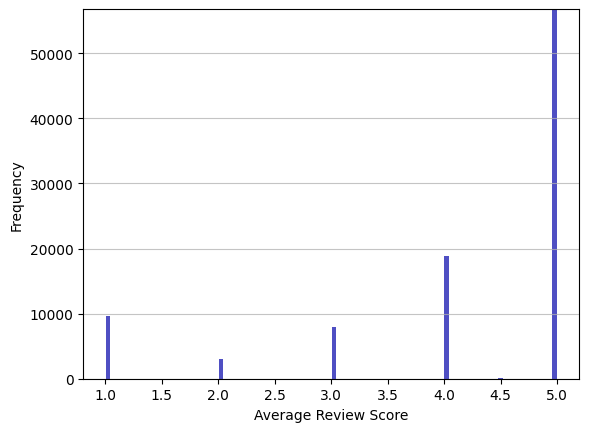

In [29]:
n, bins, patches = plt.hist(x=orderreview_sum1.avg_review, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Average Review Score')
plt.ylabel('Frequency')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 3630.0)

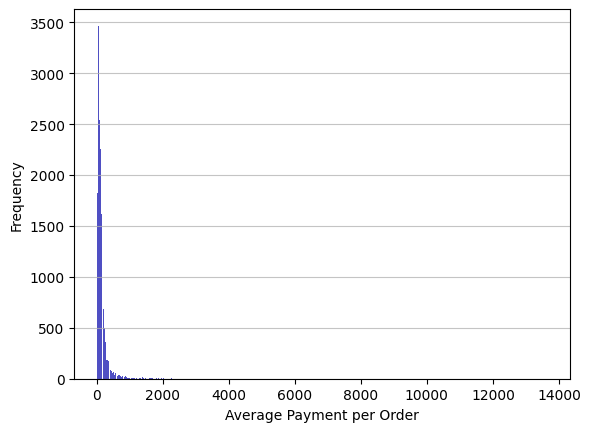

In [30]:
n, bins, patches = plt.hist(x=orderreview_sum1.avg_payment, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Average Payment per Order')
plt.ylabel('Frequency')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [31]:
np.quantile(np.array(orderreview_sum1.avg_payment),[0.25,0.5,0.75])

array([ 60.64 , 102.315, 171.13 ])

Now you might be wondering, what's the use of these plots? Let me guide you one by one:
1. The histogram of the review score shows most the customers are satisfied when making their purchase, shown by the significantly high numbers of 5 star reviews.
2. The majority of the average payment per order are lower than 2000. But there are some high payments reaching nearly 14000. This is not an outlier because this high payment could represent an expensive or a huge bulk purchase from the customer.

Overall, both variables are appropiate to be used in the model. Even so, we still need to understand the distribution of the payment amount to decide a better threshold to classify. I've created an algorithm which shows the proportion of the payments that are higher than a certain boundary amount. The boundary amounts that I'm using is between 200 and 2000 since the 3rd quantile of the payments is below 200 and majority of the payments are below 2000.

In [32]:
check = pd.DataFrame({})
pmt = []
prop = []
for pmts in list(np.linspace(200,2000,100)):
    pmt.append(pmts)
    prop.append(orderreview_sum1[orderreview_sum1.avg_payment > pmts].shape[0]/orderreview_sum1.shape[0]*100)
check['pmt'] = pmt
check['prop'] = prop
check[check.prop < 5]

,pmt,prop
13,436.363636,4.885052
14,454.545455,4.608304
15,472.727273,4.332594
16,490.909091,4.109745
17,509.090909,3.936649
...,...,...
95,1927.272727,0.224922
96,1945.454545,0.214557
97,1963.636364,0.209374
98,1981.818182,0.204192


I've filtered the result of the algorithm to only show proportions below 5% because I consider this as low proportion. With the result, we decide the best threshold for the payment is 200 & 500 (you can use 400 instead since the proportion of payments already lower than 5% at that point). On the other hand, the review score will use 3 stars as the threshold since 3 stars already acts as the middle ground of reviews (you can also use the average review score if you want).

{'whiskers': [<matplotlib.lines.Line2D at 0x7f38c568e080>,
 'caps': [<matplotlib.lines.Line2D at 0x7f38c568e5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f38c568dde0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f38c568eb00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f38c568eda0>],
 'means': []}

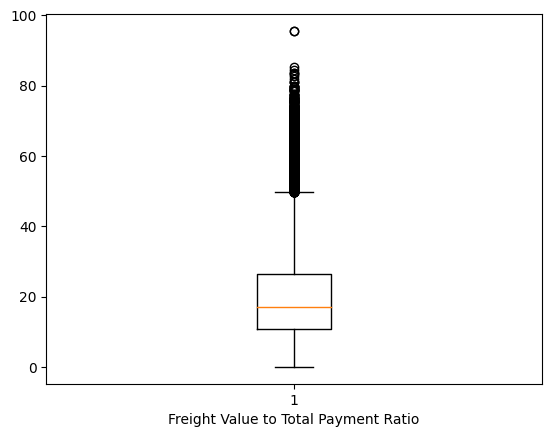

In [33]:
fig1, ax1 = plt.subplots()
plt.xlabel("Freight Value to Total Payment Ratio")
ax1.boxplot(orderreview_sum1.freight_ratio)

As we can see, most of the freight ratios are below 50%, which is normal since it's less likely for the customers to make a purchase when the freight value covers most of the payment. So let's set 50% as our threshold for the freight ratio.

#### Here are the summary of the labeling algorithm

The conditions:
- 0 - Will not return
- 1 - Will return

Here are the labeling rules for returning customers:
- Review score > 3 with payment < 200. High payment with low review might indicates an unsatisfactory condition of the purchase.
- Review score >= 4 disregarding the payment amount.
- Freight Ratio < 50%

In [34]:
will_return =[]
pmt_bounds = [200,500]
for (review,pmt,freight) in list(zip(orderreview_sum1.avg_review,orderreview_sum1.avg_payment,orderreview_sum1.freight_ratio)):
    if review < 3 :
        will_return.append(0)
    elif review == 3:
        if pmt < pmt_bounds[0]:
            if freight > 50:
                will_return.append(0)
            else:
                will_return.append(1)
        elif pmt_bounds[0] <= pmt < pmt_bounds[1]:
            will_return.append(0)
        elif pmt > pmt_bounds[1]:
            will_return.append(0)
    else:
        if freight > 50:
            will_return.append(0)
        else:
            will_return.append(1)

In reality, the returning decision would not be as perfect as the result from the algorithm before. Hence, we should switch some of the results to add unpredictable situations, e.g. not returning but gave 5 star review.

In [35]:
idx = np.random.randint(0, len(will_return), size=5000, dtype=int)
for i in list(idx):
    if will_return[i]==0:
        will_return[i]=1
    else:
        will_return[i]=0

In this simulation, we will use logistic regression and random forest as our models (let's not overkill the modeling process with more complex models lol). The following codes will show you how to prepare the model training & prediction.

### Scenario 1 - Review Score & Average Payment per Order

In [36]:
from sklearn.model_selection import train_test_split
x = orderreview_sum1.drop(['customer_id','order_id','freight_ratio'], axis = 1)
y = will_return
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [37]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix

import seaborn as sns

In [38]:
def rocplot(y_test, prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    plt.plot([0, 1], [0, 1], linestyle=':')
    
    # ROC Curve Plot Settings
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
def train(model):
    print('training & predicting model')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    prob = model.predict_proba(x_test)[:,1]
    rocplot(y_test, prob)
    score = metrics.roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    cnfmat(y_test, y_pred)
    print("test accuracy: {:.3f}%".format(acc*100))
    print(f'AUC score: {score}')

def cnfmat(y_test, y_pred):
    CMatrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(CMatrix, annot=True, cmap='BuPu')
    TP = CMatrix[0][0]
    TN = CMatrix[1][1]
    FN = CMatrix[1][0]
    FP = CMatrix[0][1]
    print('Testing Accuracy: ', (TP+TN)/(TP+TN+FN+FP))
    

training & predicting model


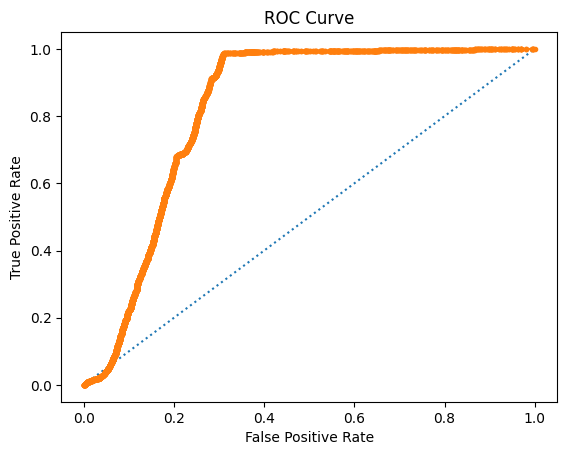

Testing Accuracy:  0.9165837479270315
test accuracy: 91.658%
AUC score: 0.8026676321675154


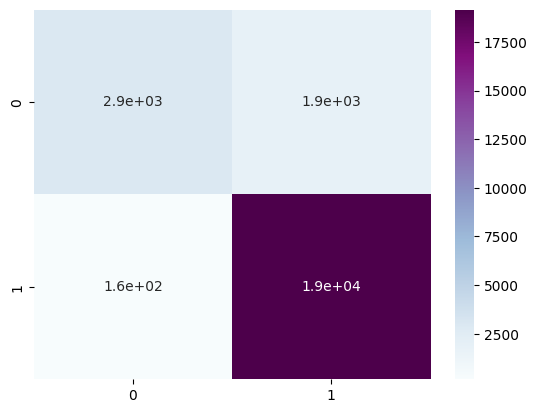

In [39]:
model1 = linear_model.LogisticRegression()
train(model1)

training & predicting model


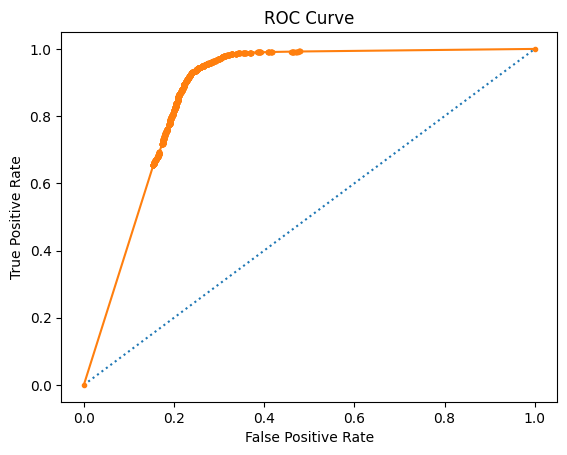

Testing Accuracy:  0.910530679933665
test accuracy: 91.053%
AUC score: 0.8402369315096883


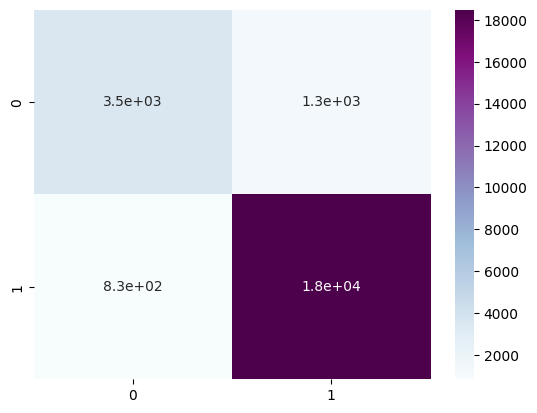

In [40]:
model2 = RandomForestClassifier(n_estimators=30)
train(model2)    

From both models, we can see that the random forest is better to be used than the logistic regression according to the AUC. Since the AUC only differs for a few percent, let's use the logistic regression result for this scenario.

training & predicting model


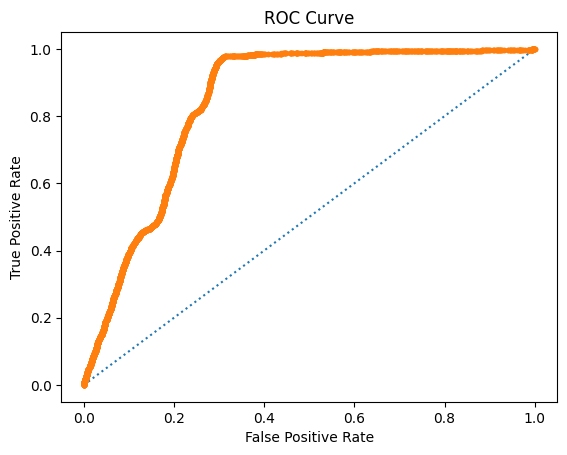

Testing Accuracy:  0.8988391376451078
test accuracy: 89.884%
AUC score: 0.8270659379796994


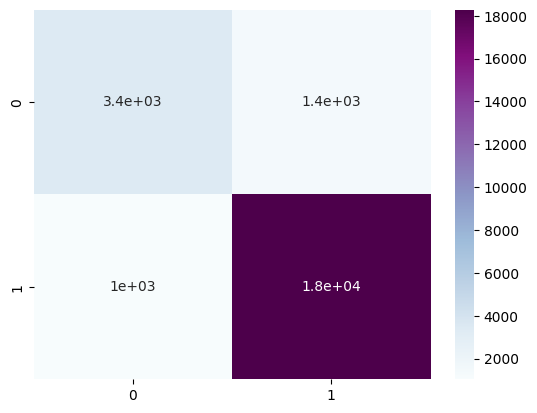

In [41]:
model3 = GaussianNB()
train(model3)

training & predicting model


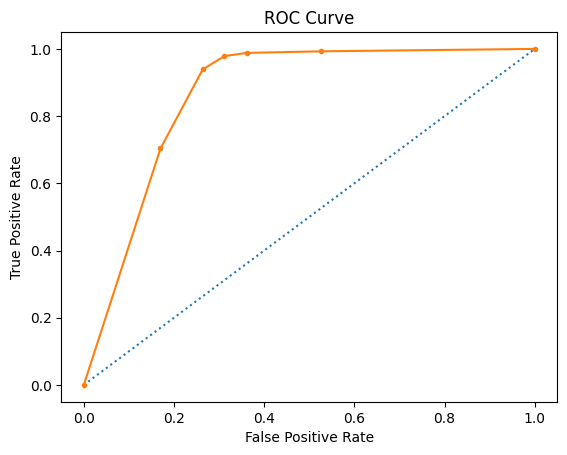

Testing Accuracy:  0.9209784411276949
test accuracy: 92.098%
AUC score: 0.8334456679665345


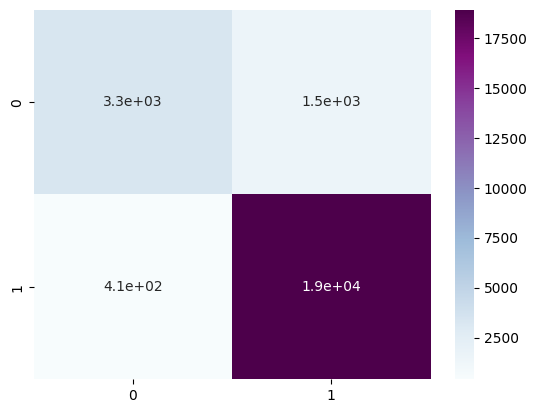

In [42]:
model4 = KNeighborsClassifier(n_neighbors=5)
train(model4)

training & predicting model


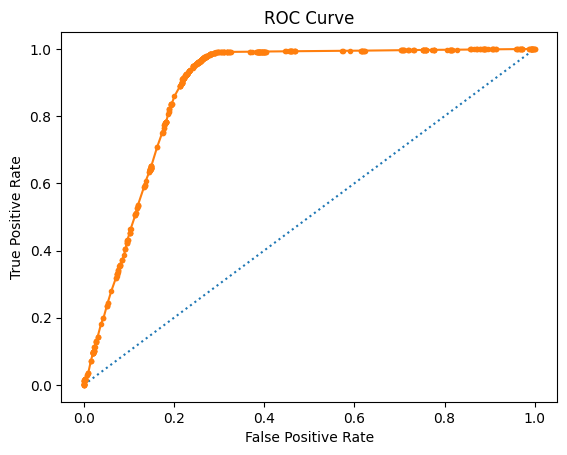

Testing Accuracy:  0.9328358208955224
test accuracy: 93.284%
AUC score: 0.8459370778587344


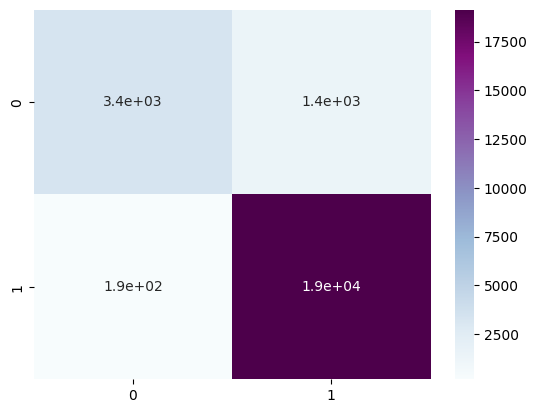

In [43]:
model5 = xgb.XGBClassifier(max_depth=3, eta=0.1, objective='multi:softmax', num_class=3)
train(model5)

training & predicting model


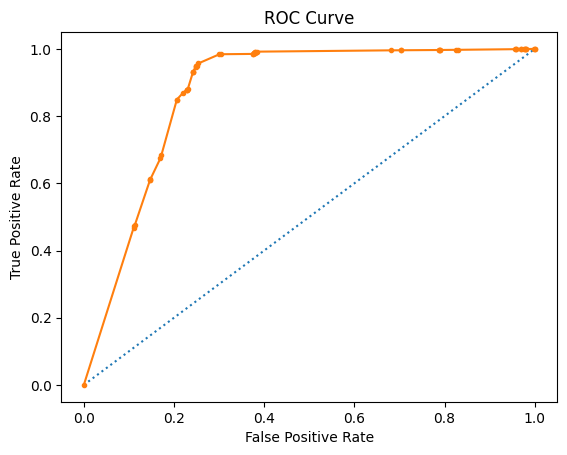

Testing Accuracy:  0.9157960199004975
test accuracy: 91.580%
AUC score: 0.804838472216346


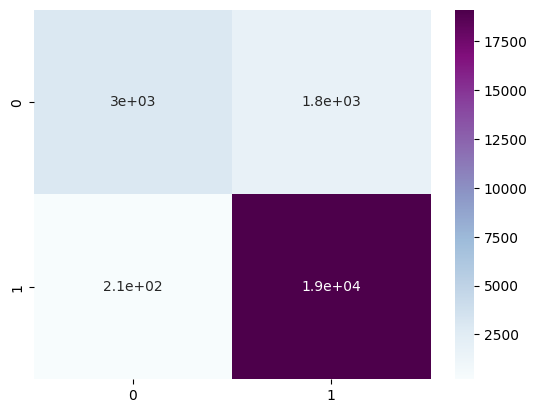

In [44]:
model6 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
train(model6)

training & predicting model


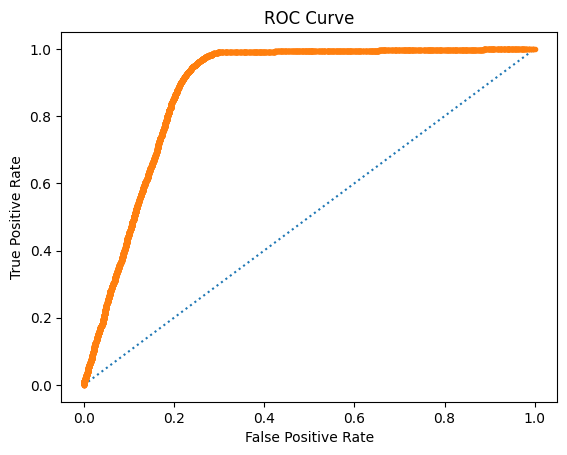

Testing Accuracy:  0.9311774461028193
test accuracy: 93.118%
AUC score: 0.8408298254172585


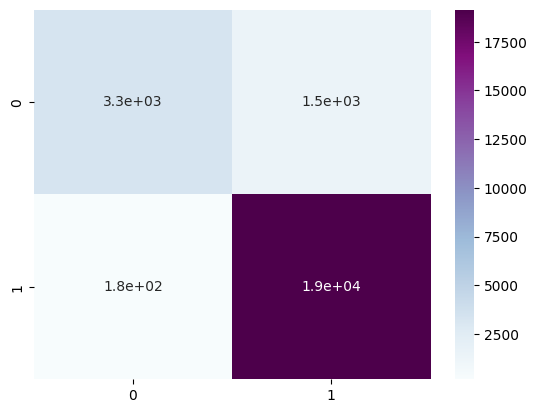

In [45]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
model7 = AdaBoostClassifier(estimator=rf, n_estimators=100, learning_rate=0.1)
train(model7)

In [46]:
testdata = orderreview_sum1.iloc[x_test.index].reset_index(drop=True)
testdata['will_return']=model5.predict(x_test)
testdata

,customer_id,order_id,avg_review,total_payment,avg_payment,freight_ratio,will_return
0,11f0c49caade1b82c30832ba7cb8fb5c,0cdea1c34ce2e9ca670b2e6df1d6c207,1.0,70.25,70.25,21.722420,0
1,e6c4ccb0245f6543cf63f264f78b127d,e4b0a27c86f8084e7e42e7602ecd6b29,5.0,141.79,141.79,22.427534,1
2,c3b0b7386717984ceb75277f0dccfaff,a02db77e1f2b1eb32c2cf8793740843d,5.0,56.21,56.21,15.513254,1
3,1617b1357756262bfa56ab541c47bc16,03caa2c082116e1d31e67e9ae3700499,1.0,13664.08,13664.08,0.204990,0
4,7bddbcc91c2a6935d6c06d3cdeced6dd,e11ac0d86982b86bcde829263d5a38ec,1.0,75.29,75.29,20.321424,0
...,...,...,...,...,...,...,...
24115,98ba4b7dc27586a623a04479a55cacdd,d2857f1d626d6c49882e77dea44a3e80,5.0,97.70,97.70,10.266121,1
24116,0b6f07bb76585814879c04843fdbe504,bd7328facab3b5c696a8a685b0ddacff,4.0,150.74,150.74,27.690062,1
24117,21cfe8ae0bbbc0853ed7b1532f3dd7ea,a1031a3fcd990edb954ba03274a2c39d,4.0,568.61,568.61,3.098785,1
24118,bd807d4c61069902ee1fe9c66e34b04e,fd7ba8ea32a3fdc2cf69e8697b00dd6a,5.0,44.09,44.09,31.980041,1


In [47]:
testdata.to_csv('testdata.csv', index=False)

### Scenario 2 - Freight Ratio Added

In [48]:
x = orderreview_sum1.drop(['customer_id','order_id'], axis = 1)
y = will_return
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

training & predicting model


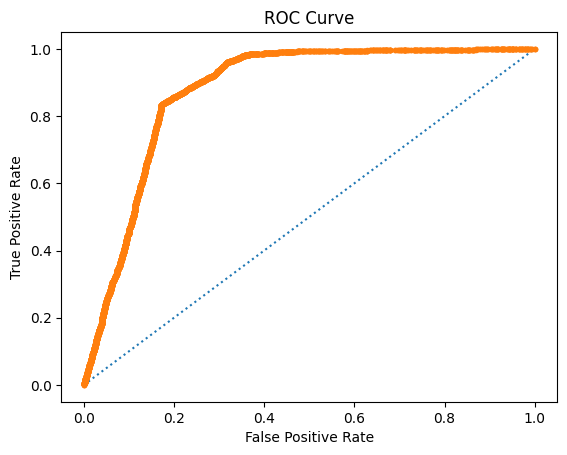

Testing Accuracy:  0.9090796019900498
test accuracy: 90.908%
AUC score: 0.8135942839941379


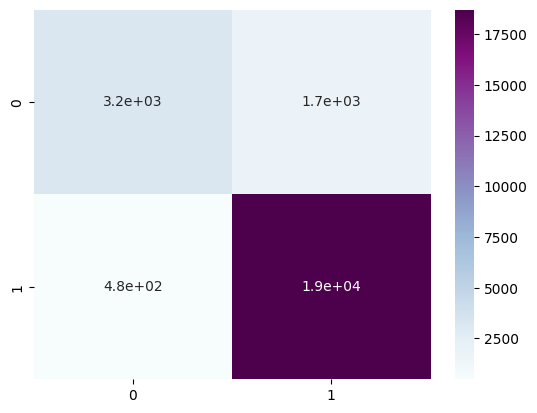

In [49]:
model8 = linear_model.LogisticRegression()
train(model8)

training & predicting model


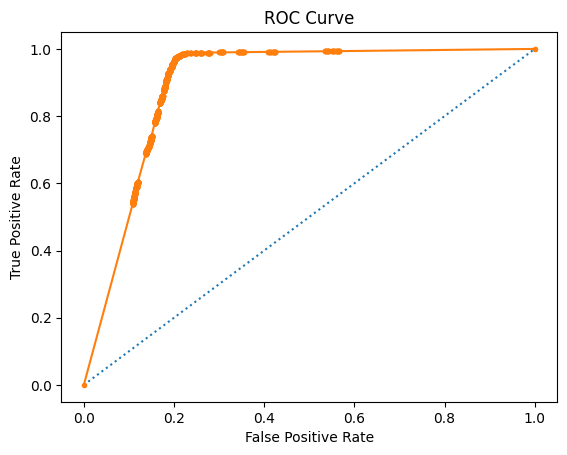

Testing Accuracy:  0.9386401326699834
test accuracy: 93.864%
AUC score: 0.884574629319652


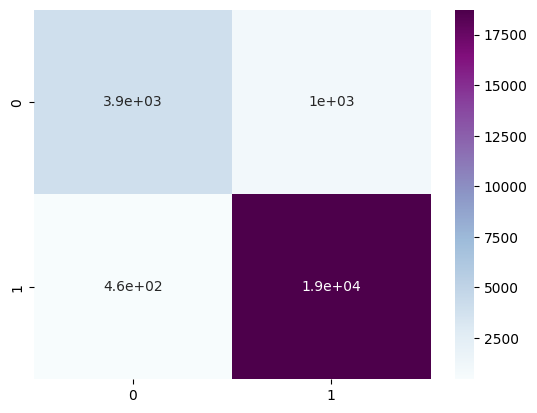

In [50]:
model9 = RandomForestClassifier(n_estimators=30)
train(model9)    

The result from the random forest model shows a significant increase unlike in the previous scenario. So let's use the predictions from the random forest model since it has higher AUC.

training & predicting model


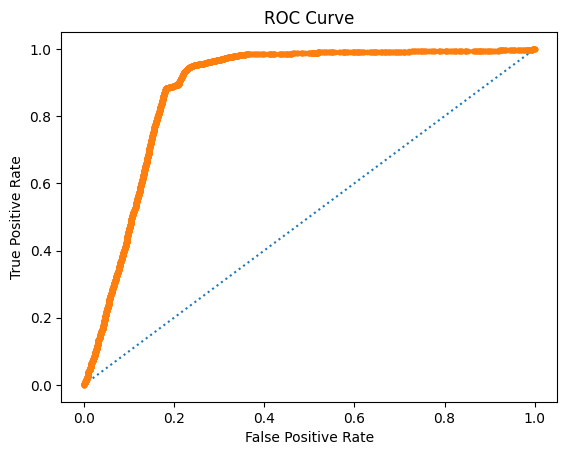

Testing Accuracy:  0.912106135986733
test accuracy: 91.211%
AUC score: 0.8407187518540326


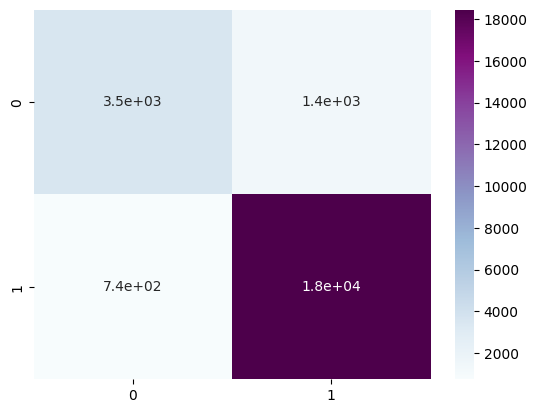

In [51]:
model10 = GaussianNB()
train(model10)

training & predicting model


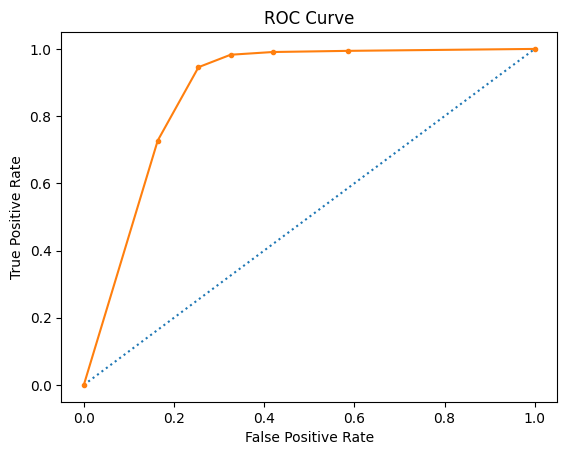

Testing Accuracy:  0.9197761194029851
test accuracy: 91.978%
AUC score: 0.8285455841811054


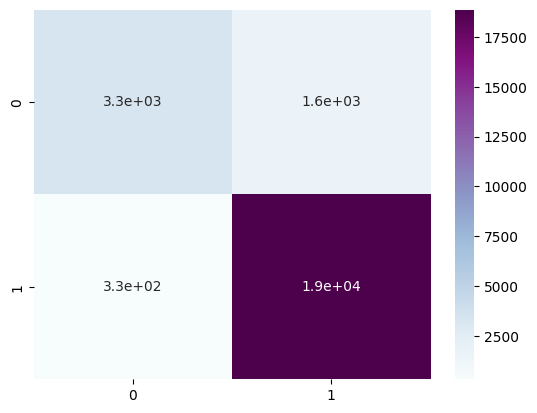

In [52]:
model11 = KNeighborsClassifier(n_neighbors=5)
train(model11)

training & predicting model


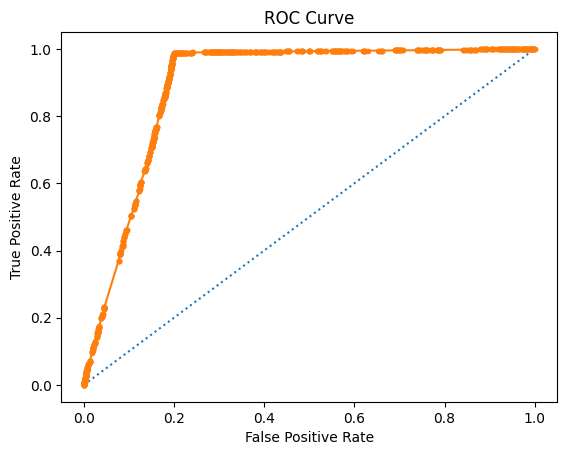

Testing Accuracy:  0.9498341625207297
test accuracy: 94.983%
AUC score: 0.8936459735910518


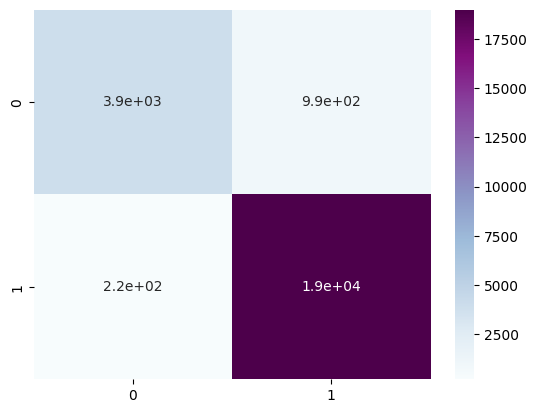

In [53]:
model12 = xgb.XGBClassifier(max_depth=3, eta=0.1, objective='multi:softmax', num_class=3)
train(model12)

training & predicting model


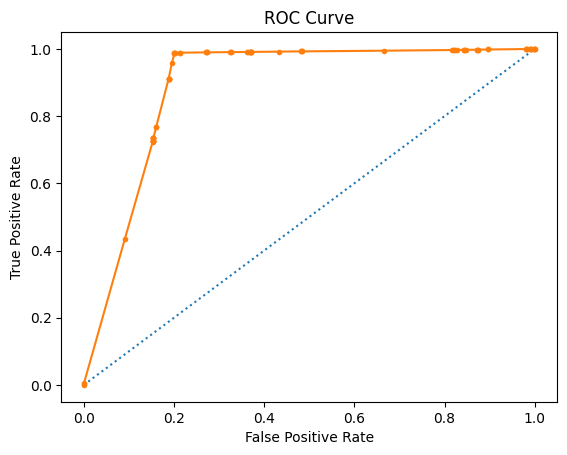

Testing Accuracy:  0.9364013266998341
test accuracy: 93.640%
AUC score: 0.8590778057090922


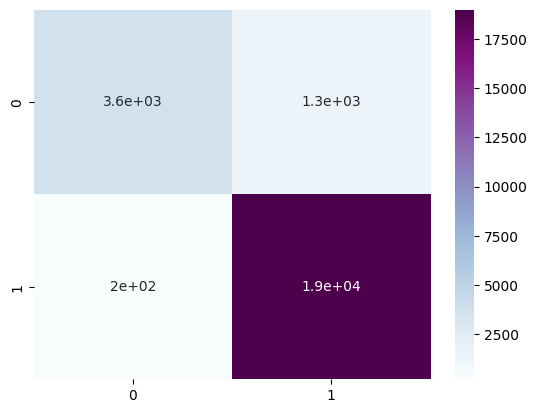

In [54]:
model13 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
train(model13)

training & predicting model


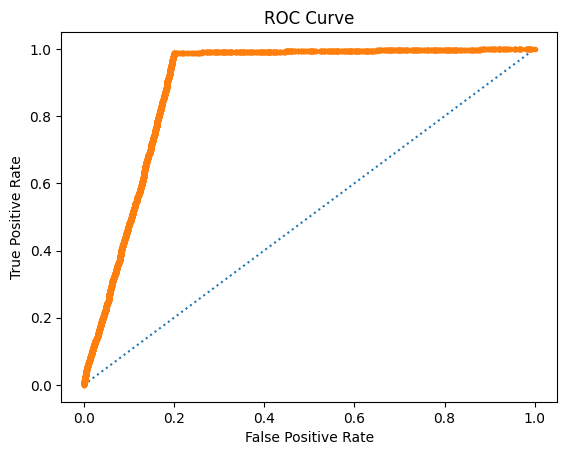

Testing Accuracy:  0.9498341625207297
test accuracy: 94.983%
AUC score: 0.8936459735910518


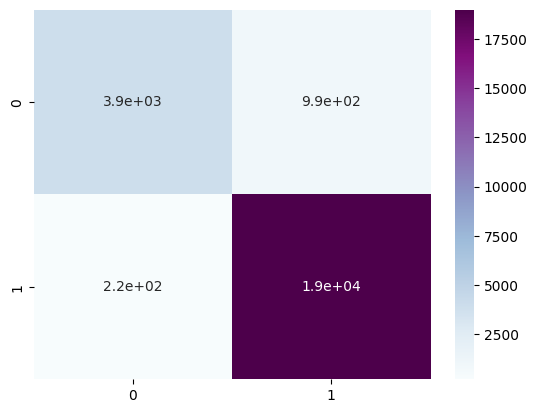

In [55]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
model14 = AdaBoostClassifier(estimator=rf, n_estimators=100, learning_rate=0.1)
train(model14)

In [56]:
testdata1 = orderreview_sum1.iloc[x_test.index].reset_index(drop=True)
testdata1['will_return']=model12.predict(x_test)
testdata1

,customer_id,order_id,avg_review,total_payment,avg_payment,freight_ratio,will_return
0,4a913a170c26e3c8052ed0202849b5a8,3e470077b690ea3e3d501cffb5e0c499,4.0,166.98,166.98,7.773386,1
1,9cf42547a1ce7ce81a82b6760b4fa475,37f5ca0f750ed3aa9b86b3c4ba26ed02,5.0,182.32,182.32,8.863537,1
2,e91aacb44859273903170c37d0b8cdd7,378e8f0a8bb7b51c09f84c88add4c6a9,5.0,208.61,208.61,8.523081,1
3,3b864cf315fee8e0e4dafd9396d57248,098e7344bff99946b1a3c2c4357503bf,1.0,31.34,31.34,40.491385,0
4,1dcbfa08476cebf4fee1bc3d400389a9,9372445ddc10678e804717702a911665,2.0,53.42,53.42,20.516660,0
...,...,...,...,...,...,...,...
24115,efce0446c7a2965ea8f7e70ddb7ebd7e,adb3a0386f6e1f65d5fa85ecfc0f64a2,1.0,125.42,125.42,12.374422,0
24116,bb0801ebc512fa519601419633953eb2,8fe2e00c742ffd8ef837c0651c76166c,5.0,99.90,99.90,0.000000,1
24117,7dba19b4aa8f8741e306917190e6e950,910672810c4151ca48b6946cf9ba0418,5.0,67.82,67.82,26.422884,1
24118,9dca293f928f7a1aaa6ab447b2093234,94a1020970476388adf12c46628499be,5.0,228.62,228.62,8.188260,1


In [57]:
testdata1.to_csv('testdata1.csv', index=False)